## Setup

In [1]:
%pip install matplotlib
%pip install yfinance
%pip install scipy
%pip install seaborn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime as dt
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

/Users/cherriepoon/shadow/capstone/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
start_date = dt.date(2010,1,1)
end_date = dt.date(2023, 12,31)

In [4]:
sp = yf.download("SPY", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


## Highlighted stylized facts on the financial asset

In [5]:
spy_adj_close = sp['Adj Close']
spy_ret = np.log(spy_adj_close).diff()

<Axes: xlabel='Date'>

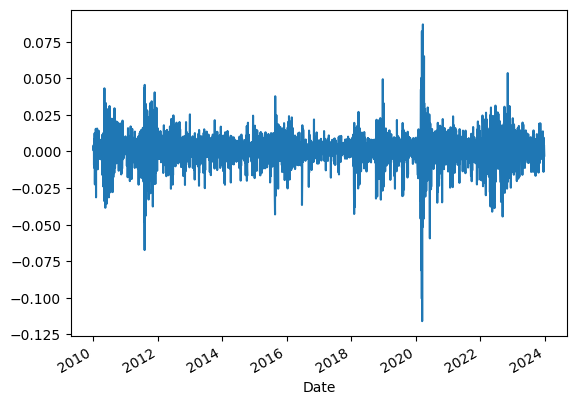

In [6]:
# plot return series to show volatility clustering
spy_ret.plot()

In [7]:
# cdf graphs to show fat tail
ref_mean = spy_ret.mean()
ref_std = spy_ret.std()

norm_reference = np.random.normal(loc=ref_mean, scale=ref_std, size=spy_ret.shape[0])


In [8]:
plot_df = pd.DataFrame({'Normal Reference': norm_reference, 'SPY Historical Returns': spy_ret}).dropna()

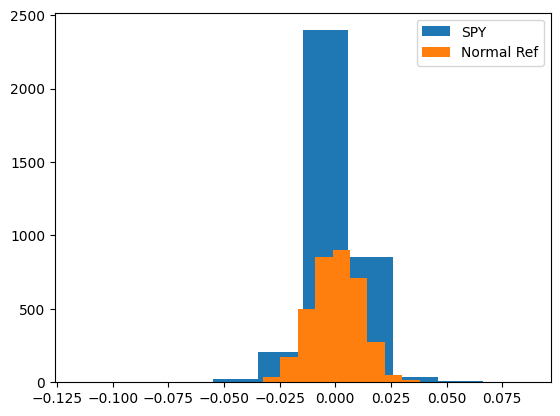

In [9]:
plt.hist(plot_df['SPY Historical Returns'], label='SPY')
plt.hist(plot_df['Normal Reference'], label='Normal Ref')
plt.legend()
plt.show()

## Prepare the data for machine learning

### Fs conditions for Swing Trader Agent

In [10]:
# temporarily we will use a fixed value 5 for the lookback days
shift_returns = spy_ret.shift(1) # make decision based on T-1 day to prevent lookahead bias
swing_return_lookback_days = 5
Fs = shift_returns - shift_returns.shift(swing_return_lookback_days)

# if Fs >0 D will follow like a momentum trader
# if Fs <0 D will revert to normal and go against the trend

### Noise Trader

In [11]:
noise_std = spy_ret.std()/ 2 # this parameters will be trained in the machine learning step

def one_noise_demand(std):
    return std * np.random.standard_normal()

demand_noise_sample = one_noise_demand(noise_std)
display(demand_noise_sample)

np.float64(-0.0008355956255344023)

### Momentum Trader

In [12]:
ewma_alpha = 0.05 # fixed parameters, to be tuned in due course
ewm_sr = spy_ret.ewm(alpha=ewma_alpha, adjust=False).mean()

ewm_lambda = 1 # we will train the Beta parameters for the momentum trader demands, so we choose lambda = 1 for simplicity

momentum_beta = 0.5 # training parameters
def one_momentum_trader(beta, ewm_t):
    return beta * np.tanh(ewm_t)


demand_momentum_sample = one_momentum_trader(momentum_beta, ewm_lambda * ewm_sr.iloc[1])
display(demand_momentum_sample)


np.float64(0.0013217868922161154)

In [13]:
spy_ret

Date
2010-01-04         NaN
2010-01-05    0.002644
2010-01-06    0.000704
2010-01-07    0.004212
2010-01-08    0.003322
                ...   
2023-12-22    0.002008
2023-12-26    0.004214
2023-12-27    0.001806
2023-12-28    0.000378
2023-12-29   -0.002899
Name: Adj Close, Length: 3522, dtype: float64

### Fundamental Trader

In [14]:
# we will use the bull-bear line (MA250) as a simple rule of thumb for the value of the asset
bb_lookback_days = 250
fundamental_v = 0.2/100 # training parameters

def one_fundamental_trader(v, pt, ma250):
    return v * (ma250 - pt)

spy_ma250 = spy_adj_close.rolling(bb_lookback_days).mean()
display(spy_ma250)

demand_fundamental_sample = one_fundamental_trader(fundamental_v, spy_adj_close.iloc[-50], spy_ma250.iloc[-50])
display(demand_fundamental_sample)

Date
2010-01-04           NaN
2010-01-05           NaN
2010-01-06           NaN
2010-01-07           NaN
2010-01-08           NaN
                 ...    
2023-12-22    418.138618
2023-12-26    418.534722
2023-12-27    418.952737
2023-12-28    419.345000
2023-12-29    419.735737
Name: Adj Close, Length: 3522, dtype: float64

np.float64(-0.027665103759765657)

### Full input data

In [15]:
input_data = pd.DataFrame({
    'Fs': Fs,
    'EWM': ewm_sr,
    'Close': spy_adj_close,
    'F_Value':  spy_ma250,
    'log_ret' :spy_ret,
}).dropna()
# basically we have use some lookback data (EWM/Fs/MA250) so our actual data for trainings starts from 2011
display(input_data)

,Fs,EWM,Close,F_Value,log_ret
Date,,,,,
2010-12-29,-0.000979,0.001718,97.787636,87.580490,0.000715
2010-12-30,-0.005606,0.001553,97.632324,87.625755,-0.001590
2010-12-31,-0.004695,0.001487,97.655624,87.670200,0.000239
2011-01-03,0.001671,0.001927,98.665184,87.718439,0.010285
2011-01-04,0.009887,0.001803,98.610825,87.764998,-0.000551
...,...,...,...,...,...
2023-12-22,0.006233,0.002233,469.225250,418.138618,0.002008
2023-12-26,0.003656,0.002332,471.206573,418.534722,0.004214
2023-12-27,-0.001396,0.002306,472.058563,418.952737,0.001806


## Parameters Calibration - Samples universe

In [44]:
# generate some random values for the parameters
from scipy.stats import qmc
sobol_sam = qmc.Sobol(d=3)
parameter_universe = sobol_sam.random_base2(m=15)

In [45]:
# sample simulation using a randomly selected params
import random
initialized_samples = random.choices(parameter_universe, k=6000)

### Illustration for 1 iteration of generating parameters to loss mappings

In [46]:
fundamental_v, momentum_beta, noise_std =initialized_samples[0]
fundamental_v, momentum_beta, noise_std 


(np.float64(0.20701147243380547),
 np.float64(0.38193235732614994),
 np.float64(0.4594974424690008))

In [47]:
display(input_data.head())
display(input_data.tail())


,Fs,EWM,Close,F_Value,log_ret
Date,,,,,
2010-12-29,-0.000979,0.001718,97.787636,87.580490,0.000715
2010-12-30,-0.005606,0.001553,97.632324,87.625755,-0.001590
2010-12-31,-0.004695,0.001487,97.655624,87.670200,0.000239
2011-01-03,0.001671,0.001927,98.665184,87.718439,0.010285
2011-01-04,0.009887,0.001803,98.610825,87.764998,-0.000551


,Fs,EWM,Close,F_Value,log_ret
Date,,,,,
2023-12-22,0.006233,0.002233,469.225250,418.138618,0.002008
2023-12-26,0.003656,0.002332,471.206573,418.534722,0.004214
2023-12-27,-0.001396,0.002306,472.058563,418.952737,0.001806
2023-12-28,-0.004256,0.002209,472.236847,419.345000,0.000378
2023-12-29,0.014332,0.001954,470.869751,419.735737,-0.002899


In [48]:
# copy trader functions from above
def one_fundamental_trader(v, pt, ma250):
    return v * (ma250 - pt)

def one_momentum_trader(beta, ewm_t):
    return beta * np.tanh(ewm_t)

def one_noise_demand(std):
    return std * np.random.standard_normal()

# start one round of simulation with the selected params

p_cur = input_data.iloc[0]['Close']
display (p_cur)

def simulate_price_series():
    p_cur = input_data.iloc[0]['Close']
    yield input_data.iloc[0].name, p_cur
    for date, fs, ewm, _, f_value, _ in input_data[1:].itertuples():
        demand = one_fundamental_trader(fundamental_v, p_cur, f_value) +  one_momentum_trader(momentum_beta, ewm) + one_noise_demand(noise_std)
        if fs >0:
            demand += one_momentum_trader(momentum_beta, ewm)
        else:
            demand += one_fundamental_trader(fundamental_v, p_cur, f_value)
        p_next = p_cur+demand
        yield date, p_next
        p_cur = p_next

sr = pd.Series(dict(simulate_price_series()))
sim_return_sr = np.log(sr).diff()

np.float64(97.78763580322266)

### Calculate the loss function

In [49]:
def absolute_hill_estimator(ret_sr, threshold = 100):
    cleaned_sr = ret_sr.copy().replace(0, np.nan).dropna().abs() # ignore 0 ret days and take absolute
    ysort = np.sort(cleaned_sr)
    iota = 1/(np.mean(np.log(ysort[0:threshold]/ysort[threshold]))) # get the tail index
    return iota

In [50]:
hist_ret_sr = input_data.log_ret
historical_hill = absolute_hill_estimator(hist_ret_sr)
sim_hill = absolute_hill_estimator(sim_return_sr)
d_hill = abs(sim_hill - historical_hill)

In [51]:
sim_vol = sim_return_sr.std()
hist_vol = hist_ret_sr.std()
d_vol = abs(sim_vol - hist_vol)

In [52]:
lags = [30, 31, 32, 60, 61, 62, 90, 91, 92]
autocorr_diff_sum = sum([abs(sim_return_sr.autocorr(l) - hist_ret_sr.autocorr(l)) for l in lags])
d_auto_corr = autocorr_diff_sum/ len(lags)

In [53]:
sqaured_auto_corr_diff_sum = sum([abs(np.square(sim_return_sr).autocorr(l) - np.square(hist_ret_sr).autocorr(l)) for l in lags])
d_auto_corr_squared = sqaured_auto_corr_diff_sum/ len(lags)

In [54]:
loss = d_hill + d_vol + d_auto_corr + d_auto_corr_squared

In [55]:
def distance_loss_function(hist_ret, sim_ret):
    historical_hill = absolute_hill_estimator(hist_ret)
    sim_hill = absolute_hill_estimator(sim_ret)
    d_hill = abs(sim_hill - historical_hill)

    sim_vol = sim_ret.std()
    hist_vol = hist_ret.std()
    d_vol = abs(sim_vol - hist_vol)

    lags = [30, 31, 32, 60, 61, 62, 90, 91, 92]
    autocorr_diff_sum = sum([abs(sim_ret.autocorr(l) - hist_ret.autocorr(l)) for l in lags])
    d_auto_corr = autocorr_diff_sum/ len(lags)

    sqaured_auto_corr_diff_sum = sum([abs(np.square(sim_ret).autocorr(l) - np.square(hist_ret).autocorr(l)) for l in lags])
    d_auto_corr_squared = sqaured_auto_corr_diff_sum/ len(lags)
    return d_hill + d_vol + d_auto_corr + d_auto_corr_squared

In [56]:
surrogate_training_data = pd.DataFrame({'fundamental_v': fundamental_v, 'momentum_beta': momentum_beta, 'noise_std':noise_std , 'loss': loss}, index=[0])
surrogate_training_data

,fundamental_v,momentum_beta,noise_std,loss
0,0.207011,0.381932,0.459497,0.547107


This shows how 1 iteration of params => loss will be generated for training the surrogate model, now we will create 10_000 points

### Generating all mappings

In [95]:
hist_ret_sr = input_data.log_ret
training_set_1 = {(v,beta,std) for v,beta,std in initialized_samples}
def generate_trainings(train_data):
    for idx, (fundamental_v, momentum_beta, noise_std) in enumerate(train_data):
        def simulate_price_series():
            p_cur = input_data.iloc[0]['Close']
            yield input_data.iloc[0].name, p_cur
            for date, fs, ewm, _, f_value, _ in input_data[1:].itertuples():
                demand = one_fundamental_trader(fundamental_v, p_cur, f_value) +  one_momentum_trader(momentum_beta, ewm) + one_noise_demand(noise_std)
                if fs >0:
                    demand += one_momentum_trader(momentum_beta, ewm)
                else:
                    demand += one_fundamental_trader(fundamental_v, p_cur, f_value)
                p_next = p_cur+demand
                yield date, p_next
                p_cur = p_next
        
        sr = pd.Series(dict(simulate_price_series()))
        sim_return_sr = np.log(sr).diff()
        loss = distance_loss_function(hist_ret_sr, sim_return_sr)
        print('.', end='\n' if idx %400 ==0 and idx >0 else '')
        yield fundamental_v,   momentum_beta,  noise_std ,   loss

In [ ]:
labelled_data_1 = list(generate_trainings(training_set_1))

.................................................................................................................................................................................................................................................................................................................................................................................................................
................................................................................................................................................................................................................................................................................................................................................................................................................
.....................................................................................................................................................................................................

In [ ]:
xgboost_train_data = pd.DataFrame(labelled_data_1, columns=['fundamental_v',   'momentum_beta',  'noise_std' ,   'loss'])

In [83]:
xgboost_train_data.to_csv('xg_train_data.csv')

## Train XGB for efficient loss estimation without actually running the demand model

In [84]:
import xgboost as xgb
import pandas as pd
xgboost_train_data = pd.read_csv('xg_train_data.csv',index_col=0)

In [85]:
xgboost_train_data

,fundamental_v,momentum_beta,noise_std,loss
0,0.790044,0.160668,0.203786,0.348881
1,0.295818,0.478174,0.270008,0.369558
2,0.097978,0.140863,0.537308,0.356803
3,0.315018,0.807071,0.074952,0.517568
4,0.320663,0.096098,0.461914,0.378570
...,...,...,...,...
5446,0.242608,0.831971,0.219895,0.653947
5447,0.801348,0.333105,0.605539,0.445973
5448,0.407352,0.594255,0.927488,0.602350
5449,0.252412,0.576667,0.852707,0.715041


In [86]:
xgb_regressor = xgb.XGBRegressor(tree_method="hist")

In [87]:
xgb_regressor.fit(xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']], xgboost_train_data[['loss']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [100]:
# predict_loss from initialized_samples
universe_set = {(a,b,c) for a,b,c in parameter_universe}
remaining_set = universe_set - training_set_1
out = xgb_regressor.predict(list(remaining_set))

In [108]:
predict_df = pd.DataFrame(remaining_set, columns = ['fundamental_v', 'momentum_beta', 'noise_std'])
predict_df['predict_dloss'] = out
predict_df

,fundamental_v,momentum_beta,noise_std,predict_dloss
0,0.060083,0.740435,0.235582,0.600973
1,0.444964,0.176684,0.933478,0.503918
2,0.843827,0.962877,0.580520,0.446987
3,0.088127,0.391217,0.284480,0.559075
4,0.714040,0.159696,0.706608,0.485745
...,...,...,...,...
27312,0.105286,0.633476,0.621316,0.601552
27313,0.889199,0.919995,0.353800,0.462740
27314,0.496904,0.948662,0.115208,0.461611
27315,0.925117,0.150277,0.379090,0.478209


In [109]:
predict_df['predict_dloss'].describe()

count    27317.000000
mean         0.509144
std          0.067555
min          0.295849
25%          0.465587
50%          0.499737
75%          0.545257
max          1.371744
Name: predict_dloss, dtype: float64

In [110]:
predict_df.sort_values('predict_dloss')

,fundamental_v,momentum_beta,noise_std,predict_dloss
17339,0.980287,0.349034,0.696785,0.295849
4386,0.774508,0.985241,0.844768,0.308622
9089,0.740643,0.993077,0.730921,0.309806
23297,0.705663,0.049138,0.404608,0.311836
2017,0.497754,0.763939,0.294551,0.312383
...,...,...,...,...
4585,0.005324,0.220015,0.022435,1.189501
20692,0.002596,0.878550,0.000263,1.218323
1774,0.010352,0.204706,0.010137,1.246249
8845,0.011482,0.253249,0.017346,1.275060


### Incrementally add new labelled data by taking the parameter set with the lowest predict_dloss

In [124]:
# we will get the lowest 600 predicted params + 200 randomly selected params for further simulating, and then to fit xgboost again

next_training_df = predict_df.sort_values('predict_dloss').iloc[:600][['fundamental_v','momentum_beta','noise_std']]
random_df = predict_df.iloc[600:].sample(n=200, random_state=1)[['fundamental_v','momentum_beta','noise_std']]

In [ ]:
next_training_set = set(pd.concat([next_training_df, random_df]).itertuples(index=False, name=None))
labelled_data = list(generate_trainings(next_training_set))
xgboost_train_data_supp = pd.DataFrame(labelled_data, columns=['fundamental_v',   'momentum_beta',  'noise_std' ,   'loss'])
all_xgboost_train_data = pd.concat([xgboost_train_data, xgboost_train_data_supp])

.................................................................................................................................................................................................................................................................................................................................................................................................................
...........................................................................................................................................................................................................................................................................................................................................................................................................

In [132]:
xgb_regressor.fit(all_xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']], all_xgboost_train_data[['loss']])
all_training_set = training_set_1 | next_training_set
remaining_set = universe_set - all_training_set
out = xgb_regressor.predict(list(remaining_set))
predict_df = pd.DataFrame(remaining_set, columns = ['fundamental_v', 'momentum_beta', 'noise_std'])
predict_df['predict_dloss'] = out
predict_df

,fundamental_v,momentum_beta,noise_std,predict_dloss
0,0.060083,0.740435,0.235582,0.570776
1,0.444964,0.176684,0.933478,0.514495
2,0.843827,0.962877,0.580520,0.391793
3,0.088127,0.391217,0.284480,0.584042
4,0.714040,0.159696,0.706608,0.448049
...,...,...,...,...
26516,0.105286,0.633476,0.621316,0.594729
26517,0.889199,0.919995,0.353800,0.544334
26518,0.496904,0.948662,0.115208,0.507634
26519,0.925117,0.150277,0.379090,0.458962


In [134]:
predict_df['predict_dloss'].describe()

count    26521.000000
mean         0.512845
std          0.067058
min          0.325846
25%          0.469919
50%          0.501981
75%          0.546793
max          1.373340
Name: predict_dloss, dtype: float64

In [ ]:
# check the predict error now:
check_output = xgb_regressor.predict(list(all_xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']].itertuples(index=False, name=None)))
predict_with_true = all_xgboost_train_data.copy()
predict_with_true['predict'] = check_output
avg_loss = ((predict_with_true['predict'] - predict_with_true['loss'])/predict_with_true['loss']).mean()
print(f'Avg loss after supplemented training')

np.float64(0.03565111076846461)

In [137]:
# here we will repeat the extra training 5 more times

def re_train(predict_df, all_train_data, training_set):
    next_training_df = predict_df.sort_values('predict_dloss').iloc[:600][['fundamental_v','momentum_beta','noise_std']]
    random_df = predict_df.iloc[600:].sample(n=200, random_state=1)[['fundamental_v','momentum_beta','noise_std']]
    next_training_set = set(pd.concat([next_training_df, random_df]).itertuples(index=False, name=None))
    labelled_data = list(generate_trainings(next_training_set))
    xgboost_train_data_supp = pd.DataFrame(labelled_data, columns=['fundamental_v',   'momentum_beta',  'noise_std' ,   'loss'])
    all_xgboost_train_data = pd.concat([all_train_data, xgboost_train_data_supp])


    xgb_regressor.fit(all_xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']], all_xgboost_train_data[['loss']])
    all_training_set = training_set | next_training_set
    remaining_set = universe_set - all_training_set
    out = xgb_regressor.predict(list(remaining_set))
    predict_df = pd.DataFrame(remaining_set, columns = ['fundamental_v', 'momentum_beta', 'noise_std'])
    predict_df['predict_dloss'] = out
    
    # check the predict error now:
    check_output = xgb_regressor.predict(list(all_xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']].itertuples(index=False, name=None)))
    predict_with_true = all_xgboost_train_data.copy()
    predict_with_true['predict'] = check_output
    avg_loss = ((predict_with_true['predict'] - predict_with_true['loss'])/predict_with_true['loss']).mean()
    print(f'Avg loss after re-training {avg_loss:.4f}')
    return predict_df, all_xgboost_train_data, all_training_set




for i in range(5):
    print(f'Re-train XGB repeating the steps, loop ={i+1}')
    predict_df,all_xgboost_train_data, all_training_set= re_train(predict_df,all_xgboost_train_data, all_training_set)


Re-train XGB repeating the steps, loop =1
.................................................................................................................................................................................................................................................................................................................................................................................................................
..........................................................................................................................................................................................................................................................................................................................................................................................................Avg loss after re-training 0.0368
Re-train XGB repeating the steps, loop =2
......................................................................................

In [139]:
final_model = xgb_regressor.fit(all_xgboost_train_data[['fundamental_v', 'momentum_beta', 'noise_std']], all_xgboost_train_data[['loss']])

final_loss_pred = final_model.predict(parameter_universe)
result_df = pd.DataFrame(parameter_universe, columns=['fundamental_v', 'momentum_beta', 'noise_std'])
result_df['predict_dloss'] = final_loss_pred
result_df

,fundamental_v,momentum_beta,noise_std,predict_dloss
0,0.260555,0.619588,0.182637,0.480168
1,0.513668,0.174049,0.898094,0.528546
2,0.918853,0.862739,0.494943,0.449487
3,0.167815,0.432856,0.709423,0.618556
4,0.058074,0.946931,0.833090,0.598098
...,...,...,...,...
32763,0.058092,0.376847,0.707083,0.618377
32764,0.167831,0.987743,0.835368,0.526777
32765,0.918870,0.307852,0.120889,0.541579
32766,0.513631,0.744592,0.522209,0.506801


In [150]:
final_v,final_beta,final_std = result_df.sort_values('predict_dloss').iloc[0][['fundamental_v', 'momentum_beta', 'noise_std']]

<Axes: >

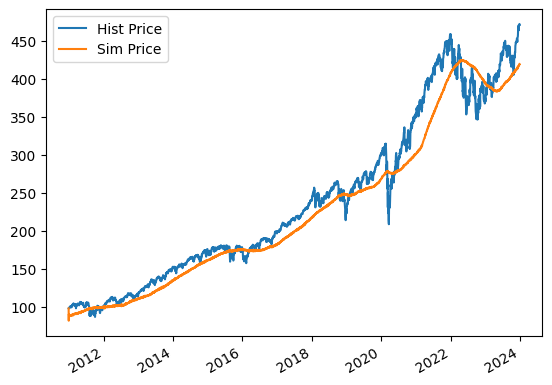

In [151]:
# now we use this final params into our ABM model, and see the series produced

def simulate_price_series_final(v, beta, std, input_data):
    p_cur = input_data.iloc[0]['Close']
    yield input_data.iloc[0].name, p_cur
    for date, fs, ewm, _, f_value, _ in input_data[1:].itertuples():
        demand = one_fundamental_trader(v, p_cur, f_value) +  one_momentum_trader(beta, ewm) + one_noise_demand(std)
        if fs >0:
            demand += one_momentum_trader(beta, ewm)
        else:
            demand += one_fundamental_trader(v, p_cur, f_value)
        p_next = p_cur+demand
        yield date, p_next
        p_cur = p_next

sim_sr_final = pd.Series(dict(simulate_price_series_final(final_v,final_beta,final_std, input_data)))
sim_return_sr_final = np.log(sr).diff()


plot_df = pd.DataFrame({'Hist Price': input_data['Close'], 'Sim Price': sim_sr_final})
plot_df.plot()

In [153]:
sim_return_sr_final.kurt()

np.float64(11.446942597567809)

In [154]:
hist_ret_sr.kurt()

np.float64(12.339129593101243)

In [167]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

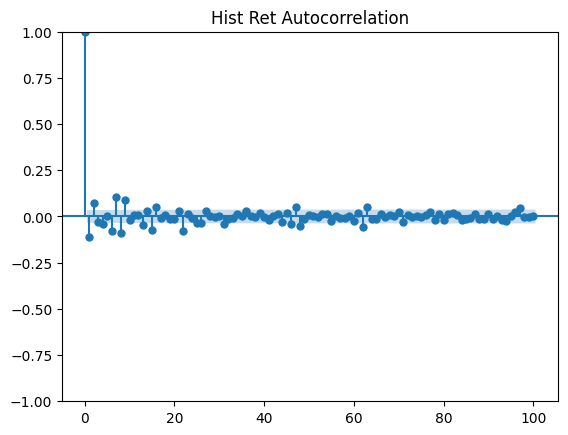

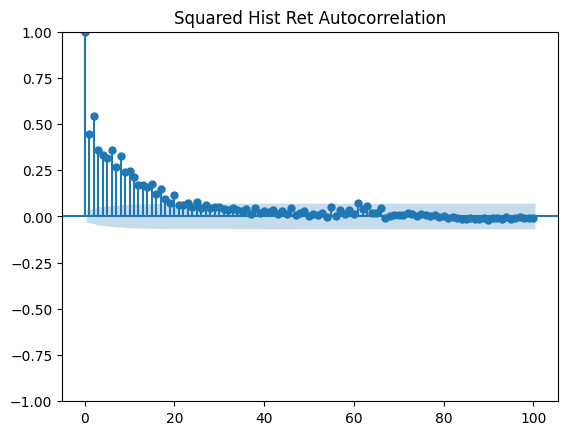

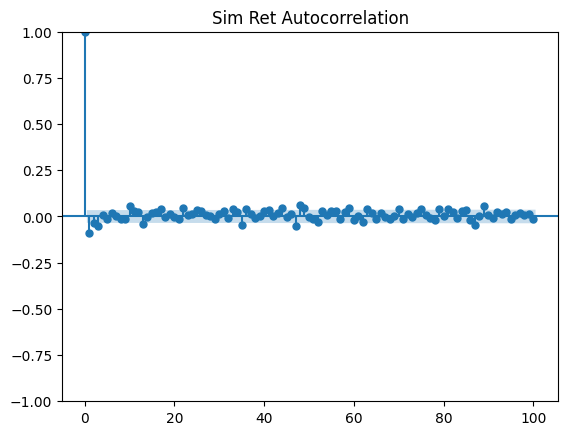

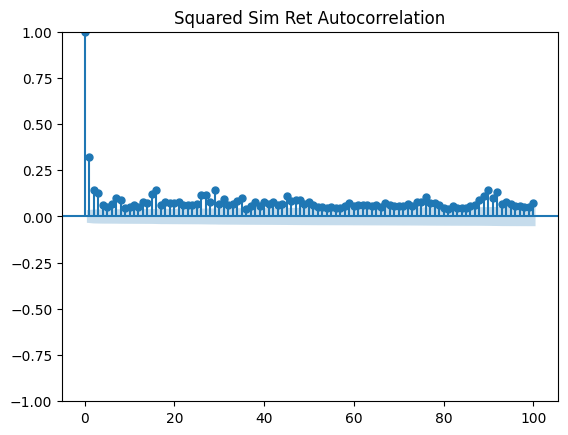

In [180]:
import matplotlib.pyplot as plt
sm.graphics.tsa.plot_acf(hist_ret_sr.values.squeeze(),lags=100 ,title='Hist Ret Autocorrelation')
sm.graphics.tsa.plot_acf(np.square(hist_ret_sr).values.squeeze(),lags=100 ,title='Squared Hist Ret Autocorrelation')

sm.graphics.tsa.plot_acf(sim_return_sr_final.dropna().values.squeeze(),lags=100 ,title='Sim Ret Autocorrelation')
sm.graphics.tsa.plot_acf(np.square(sim_return_sr_final.dropna()).values.squeeze(),lags=100 ,title='Squared Sim Ret Autocorrelation')
plt.show()